## Required imports + device for training

In [ ]:
import torch
from dataset import HelplessnessVideoDataset
from cnn_3d_model.model import HelplessnessClassifier
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import os

device = 'cpu'
if torch.backends.mps.is_available():
    device = 'mps' # Apple Silicon 
if torch.cuda.is_available():
    device = 'cuda' # Nvidia GPU
print(f'Using device: {device}')

Using device: cuda


## Creating datasets from extracted frame sequences

In [ ]:
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomRotation((-45.0, 45.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.41500069, 0.36530493, 0.33830512], [0.29042152, 0.27499218, 0.27738131])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.41500069, 0.36530493, 0.33830512], [0.29042152, 0.27499218, 0.27738131])
])

train_dataset = HelplessnessVideoDataset('../data/train', transform=train_transform)
val_dataset = HelplessnessVideoDataset('../data/val', transform=val_transform)

### Testing to ensure data augmentation works across a sequence

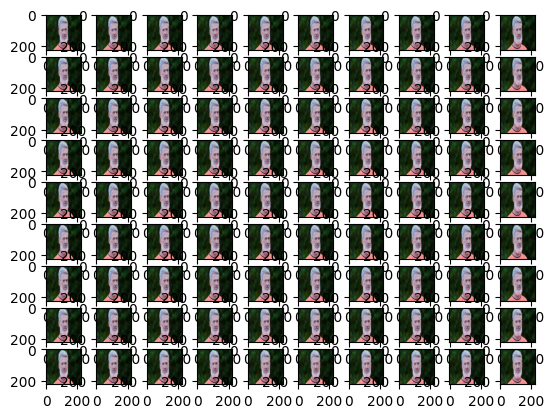

In [5]:
fig = plt.figure()
rows = 9
columns = 10
data = train_dataset[0]
for i in range(0, rows * columns):
    img = data[0][:, i, : ,:]
    img = img.permute(1, 2, 0).numpy()
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

## Training loop

In [3]:
# Hyperparameters
num_epochs = 20
batch_size = 1
learning_rate = 1e-4
weight_decay = 1e-4

# Initialize the model, dataloader, loss criterion, and optimizer
model = HelplessnessClassifier().to(device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)
crit = nn.CrossEntropyLoss() # applies softmax for us!
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

def validate():
    model.eval() # set network to evaluation
    correct, total = 0, 0
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total # return validation accuracy


# Loop over epoches to train the network
for epoch in range(num_epochs):
    model.train() # set network to train
    running_loss = 0.0
    correct, total = 0, 0

    tqdm_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for sequences, labels in tqdm_loop:
        sequences, labels = sequences.to(device), labels.to(device)

        # Forward pass
        outputs = model(sequences)
        loss = crit(outputs, labels)

        # Backward pass
        optimizer.zero_grad() # zero the gradient
        loss.backward()
        optimizer.step() # update weights

        # Track metrics
        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        # Update description in tqdm loop
        tqdm_loop.set_postfix(loss = running_loss / (tqdm_loop.n + 1), acc = correct / total)

    # Go through validation set to see current validation accuracy
    validation_accuracy = validate() * 100
    epoch_loss = running_loss / len(train_loader)
    training_accuracy = (correct / total) * 100
    print(f'Epoch {epoch+1} | Training Loss: {epoch_loss:.4f} | Training Accuracy: {training_accuracy:.2f}% | Validation Accuracy: {validation_accuracy:.2f}%')

# Save model weights to disk
weights_path = os.path.join('.', 'model_weights.pth')
torch.save(model.state_dict(), weights_path)

Epoch 1/20: 100%|██████████| 160/160 [00:47<00:00,  3.35it/s, acc=0.356, loss=1.21]


Epoch 1 | Training Loss: 1.2064 | Training Accuracy: 35.62% | Validation Accuracy: 40.00%


Epoch 2/20: 100%|██████████| 160/160 [00:58<00:00,  2.74it/s, acc=0.412, loss=1.24]


Epoch 2 | Training Loss: 1.2353 | Training Accuracy: 41.25% | Validation Accuracy: 30.00%


Epoch 3/20:  55%|█████▌    | 88/160 [00:25<00:20,  3.48it/s, acc=0.443, loss=1.08] 


KeyboardInterrupt: 